<a href="https://colab.research.google.com/github/hafizbudi/active-learning/blob/main/AL_with_CrisisMMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Project/multimodal_social_media

Mounted at /content/gdrive
/content/gdrive/My Drive/Project/multimodal_social_media


In [2]:
pip install modal

In [3]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, metrics
from dataclasses import dataclass
import dataclasses

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import margin_sampling
from modAL.uncertainty import entropy_sampling

from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import time
import random

In [6]:
@dataclass
class Experiment:
    n_samples: int
    repeat: int
    accuracy: float

def load_data(filename, nb_instance, all_instance):
  n = all_instance #number of records in file
  s = nb_instance #desired sample size
  skip = sorted(random.sample(range(1,n+1),n-s))

  #df = pd.read_csv(filename,sep="\t",nrows=nb_instance)
  df = pd.read_csv(filename,sep="\t",skiprows=skip)

  df.label_image = pd.Categorical(df.label_image)
  df['label_image_code'] = df.label_image.cat.codes

  df[['image','label_image','label_image_code']]

  df.describe()
  return df

def pre_process_image(data):
  img_arr = []
  for index,row in data.iterrows():
    read_img = cv2.imread(row['image'],0)
    img_resize = cv2.resize(read_img,(224,224))
    img_ravel = img_resize.ravel()
    img_arr.append(img_ravel)

  img_np = np.array(img_arr)

  return img_np

def random_selection_learning(n_instances, X_train, y_train):
  clf = RandomForestClassifier()
  X_selected, X_non_selected, y_selected, y_non_selected = train_test_split(X_train,y_train,train_size=n_instances,shuffle=True)
  clf.fit(X_selected,y_selected)

  return clf, X_selected, X_non_selected, y_selected, y_non_selected

def evaluate(model, X_real, y_real):
  y_predictions = model.predict(X_real)
  accuracy = metrics.accuracy_score(y_predictions,y_real)

  return accuracy

def random_forest_score(n_initial,n_queries,sampling):
  start_time = time.time()
  acc_all = []
 
  for i in n_initial:
    
    initial_idx = np.random.choice(range(len(X_train)), size=i, replace=False)
    X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]

    X_pool,y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)
    
    learner = ActiveLearner(
            estimator=RandomForestClassifier(),
            query_strategy=sampling,
            X_training=X_initial,y_training=y_initial
            )
 
    for j in range(n_queries):
      res = [learner.score(X_test,y_test)]
      query_idx, query_inst = learner.query(X_pool)
      learner.teach(query_inst, y_pool[query_idx])
      X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)

    acc = learner.score(X_test,y_test)
    acc_all.append(acc)


  final_time = time.time() - start_time

  predictions = learner.predict(X_test)
  res_classification = classification_report(y_test, predictions)

  print("--- %s seconds ---" % (final_time))

  return res_classification, acc_all, final_time

def random_forest_score_repeat(n_initial,n_queries,sampling, repeats):
  
  start_time = time.time()
  acc_all = []
  experiments = []
  
  for k in tqdm(range(repeats)):
    np.random.seed(123)
    print(k)
    for i in n_initial:
      print(i)
      initial_idx = np.random.choice(range(len(X_train)), size=i, replace=False)
      X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]

      X_pool,y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)
      
      learner = ActiveLearner(
              estimator=RandomForestClassifier(),
              query_strategy=sampling,
              X_training=X_initial,y_training=y_initial
              )
  
      for j in range(n_queries):
        res = [learner.score(X_test,y_test)]
        query_idx, query_inst = learner.query(X_pool)
        learner.teach(query_inst, y_pool[query_idx])
        X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)

      acc = learner.score(X_test,y_test)
      acc_all.append(acc)
      experiments.append(Experiment(n_samples=i, repeat=k, accuracy=acc))


  final_time = time.time() - start_time

  predictions = learner.predict(X_test)
  res_classification = classification_report(y_test, predictions)

  print("--- %s seconds ---" % (final_time))

  return res_classification, acc_all, final_time, experiments

In [7]:
# Random sampling

def random_selection_learning(n_instances, X_train, y_train):
    clf = RandomForestClassifier()
   
    X_selected, X_not_selected, y_selected, y_not_selected = \
        train_test_split(X_train, y_train, train_size=n_instances, shuffle=True)
    clf.fit(X_selected, y_selected)
    return clf, X_selected, X_not_selected, y_selected, y_not_selected

def random_sampling_policy(model, n_new_samples, X_remaining, y_remaining):
    X_new_selected, X_remaining, y_new_selected, y_remaining = \
               train_test_split(X_remaining, y_remaining,  train_size=n_new_samples, shuffle=True)
    return X_new_selected, X_remaining, y_new_selected, y_remaining

def evaluate(model, X_real, y_real):
    y_predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_real,y_predictions)
    #print(f"{accuracy}")
    return accuracy

def learning_curve(data_points, repeats, selection_policy):
    start_time = time.time()
    experiments = []
    for i in tqdm(range(repeats)):
        np.random.seed(123)
        # First learn 
        n_samples = data_points[0]
        model, X_selected, X_remaining, y_selected, y_remaining = \
            random_selection_learning(n_samples, X_train, y_train)
        acc_random = evaluate(model, X_test, y_test)
        #experiments.append(acc_random)
        experiments.append(Experiment(n_samples=n_samples, repeat=i, accuracy=acc_random))
        for n_samples in data_points[1:]:
            # Select the additional examples
            n_new_samples = n_samples - len(X_selected)
      
            X_new_selected, X_remaining, y_new_selected, y_remaining = \
                selection_policy(model, n_new_samples, X_remaining, y_remaining)
            
            X_selected = np.vstack((X_selected, X_new_selected))
            y_selected = np.hstack((y_selected, y_new_selected))
      
            model.fit(X_selected, y_selected)
            acc_random = evaluate(model, X_test, y_test)
            #experiments.append(acc_random)
            experiments.append(Experiment(n_samples=n_samples, repeat=i, accuracy=acc_random))
    final_time = time.time() - start_time

    predictions = model.predict(X_test)
    res_classification = classification_report(y_test, predictions)

    print("--- %s seconds ---" % (final_time))
    return experiments, res_classification, final_time

In [8]:
# Load CrisisMMD data

start_time = time.time()

#train_instance = 9601
#test_instance = 1534

all_train_instance = 9601
all_test_instance = 1534

train_instance = 960
test_instance = 153

train_filename = "data/task_data/task_informative_text_img_agreed_lab_train.tsv"
test_filename = "data/task_data/task_informative_text_img_agreed_lab_test.tsv"

data_train = load_data(train_filename,train_instance, all_train_instance)
data_images_train = pre_process_image(data_train)

data_test = load_data(test_filename,test_instance, all_test_instance)
data_image_test = pre_process_image(data_test)

X_train = data_images_train.reshape(train_instance,-1)
y_train = data_train['label_image_code'].values

X_test = data_image_test.reshape(test_instance,-1)
y_test = data_test['label_image_code'].values

final_time = time.time() - start_time
print("--- %s seconds ---" % (final_time))

--- 970.6564021110535 seconds ---


Train data distribution
Not Informative  311
Informative  649


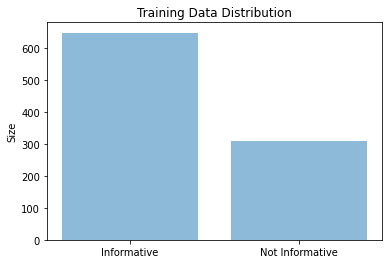

In [ ]:
print("Train data distribution")

notinf_y_train = y_train[y_train == 1]
len_notinf = len(notinf_y_train)
print("Not Informative ",len_notinf)

inf_y_train = y_train[y_train == 0]
len_inf = len(inf_y_train)
print("Informative ",len_inf)

labels = ('Informative','Not Informative')
y_pos = np.arange(len(labels))

size = [len_inf,len_notinf]
plt.bar(y_pos,size,align='center',alpha=0.5)
plt.xticks(y_pos,labels)
plt.ylabel('Size')
plt.title('Training Data Distribution')

plt.show()

Test data distribution
Not Informative  54
Informative  99


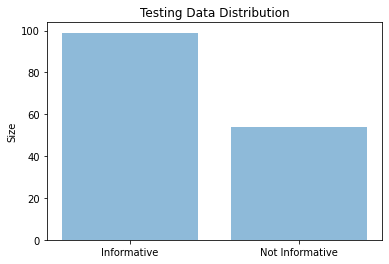

In [ ]:
print("Test data distribution")

notinf_y_test = y_test[y_test == 1]
len_notinf_test = len(notinf_y_test)
print("Not Informative ",len_notinf_test)

inf_y_test = y_test[y_test == 0]
len_inf_test = len(inf_y_test)
print("Informative ",len_inf_test)

labels = ('Informative','Not Informative')
y_pos = np.arange(len(labels))

size = [len_inf_test,len_notinf_test]
plt.bar(y_pos,size,align='center',alpha=0.5)
plt.xticks(y_pos,labels)
plt.ylabel('Size')
plt.title('Testing Data Distribution')

plt.show()

In [ ]:
n_initial = range(30,500,20)
n_queries = 10
repeats = 5

result_rf_uncertainty, result_rf_acc_uncertainty, result_rf_time_uncertainty, experiment_uncertainty = random_forest_score_repeat(n_initial,n_queries,uncertainty_sampling,repeats)
print(experiment_uncertainty)


In [ ]:
result_rf_margin, result_rf_acc_margin, result_rf_time_margin, experiment_margin = random_forest_score_repeat(n_initial,n_queries,margin_sampling,repeats)
print(experiment_margin)

In [ ]:
result_rf_entropy, result_rf_acc_entropy, result_rf_time_entropy, experiment_entropy = random_forest_score_repeat(n_initial,n_queries,entropy_sampling,repeats)
print(experiment_entropy)

In [ ]:
n_initial = range(30,500,20)
experiment_random, res_random, time_random = learning_curve(n_initial,5, random_sampling_policy)

100%|██████████| 5/5 [04:39<00:00, 55.85s/it]

--- 279.2490463256836 seconds ---


In [ ]:
print(experiment_uncertainty)
print(experiment_margin)
print(experiment_entropy)
print(experiment_random)

[Experiment(n_samples=30, repeat=0, accuracy=0.6993464052287581), Experiment(n_samples=50, repeat=0, accuracy=0.6797385620915033), Experiment(n_samples=70, repeat=0, accuracy=0.6862745098039216), Experiment(n_samples=90, repeat=0, accuracy=0.6797385620915033), Experiment(n_samples=110, repeat=0, accuracy=0.6666666666666666), Experiment(n_samples=130, repeat=0, accuracy=0.673202614379085), Experiment(n_samples=150, repeat=0, accuracy=0.6993464052287581), Experiment(n_samples=170, repeat=0, accuracy=0.7058823529411765), Experiment(n_samples=190, repeat=0, accuracy=0.6666666666666666), Experiment(n_samples=210, repeat=0, accuracy=0.6862745098039216), Experiment(n_samples=230, repeat=0, accuracy=0.6928104575163399), Experiment(n_samples=250, repeat=0, accuracy=0.6993464052287581), Experiment(n_samples=270, repeat=0, accuracy=0.7320261437908496), Experiment(n_samples=290, repeat=0, accuracy=0.7124183006535948), Experiment(n_samples=310, repeat=0, accuracy=0.6928104575163399), Experiment(n_s

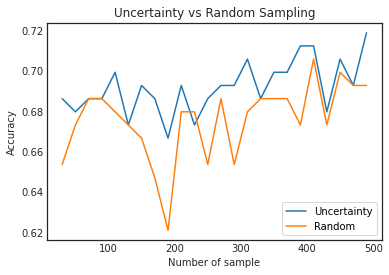

In [ ]:
def plot_learning_curve(df, name):
    # Compute percentiles
    p10 = df.groupby('n_samples').quantile(.10)['accuracy']
    p50 = df.groupby('n_samples').median()['accuracy']
    p90 = df.groupby('n_samples').quantile(.90)['accuracy']
    training_sizes= p50.index.to_numpy()

    with plt.style.context('seaborn-white'):
        plt.title('Uncertainty vs Random Sampling')
        plt.plot(training_sizes, p50, label=name)

        # show standard deviation
        #plt.fill_between(training_sizes, p10, p90,alpha=0.1)
    plt.legend(loc='lower right')
    plt.xlabel("Number of sample")
    plt.ylabel("Accuracy")
    plt.grid()
    #plt.show()

df_us = pd.DataFrame([dataclasses.asdict(e) for e in experiment_uncertainty])
df_rs = pd.DataFrame([dataclasses.asdict(e) for e in experiment_random])
plot_learning_curve(df_us, "Uncertainty")
plot_learning_curve(df_rs, "Random")

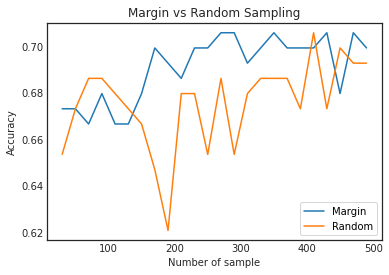

In [ ]:
def plot_learning_curve(df, name):
    # Compute percentiles
    p10 = df.groupby('n_samples').quantile(.10)['accuracy']
    p50 = df.groupby('n_samples').median()['accuracy']
    p90 = df.groupby('n_samples').quantile(.90)['accuracy']
    training_sizes= p50.index.to_numpy()

    with plt.style.context('seaborn-white'):
        plt.title('Margin vs Random Sampling')
        plt.plot(training_sizes, p50, label=name)

        # show standard deviation
        #plt.fill_between(training_sizes, p10, p90,alpha=0.1)
    plt.legend(loc='lower right')
    plt.xlabel("Number of sample")
    plt.ylabel("Accuracy")
    plt.grid()
    #plt.show()

df_ma = pd.DataFrame([dataclasses.asdict(e) for e in experiment_margin])
df_rs = pd.DataFrame([dataclasses.asdict(e) for e in experiment_random])
plot_learning_curve(df_ma, "Margin")
plot_learning_curve(df_rs, "Random")

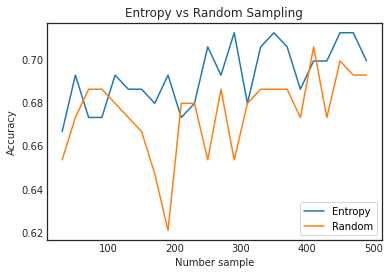

In [ ]:
def plot_learning_curve(df, name):
    # Compute percentiles
    p10 = df.groupby('n_samples').quantile(.10)['accuracy']
    p50 = df.groupby('n_samples').median()['accuracy']
    p90 = df.groupby('n_samples').quantile(.90)['accuracy']
    training_sizes= p50.index.to_numpy()

    with plt.style.context('seaborn-white'):
        plt.title('Entropy vs Random Sampling')
        plt.plot(training_sizes, p50, label=name)

        # show standard deviation
        #plt.fill_between(training_sizes, p10, p90,alpha=0.1)
    plt.legend(loc='lower right')
    plt.xlabel("Number sample")
    plt.ylabel("Accuracy")
    plt.grid()
    #plt.show()

df_en = pd.DataFrame([dataclasses.asdict(e) for e in experiment_entropy])
df_rs = pd.DataFrame([dataclasses.asdict(e) for e in experiment_random])

plot_learning_curve(df_en, "Entropy")
plot_learning_curve(df_rs, "Random")

In [ ]:
print(result_rf_uncertainty)
print(result_rf_margin)
print(result_rf_entropy)

print(result_rf_time_uncertainty)
print(result_rf_time_margin)
print(result_rf_time_entropy)

              precision    recall  f1-score   support

           0       0.73      0.92      0.81        99
           1       0.71      0.37      0.49        54

    accuracy                           0.73       153
   macro avg       0.72      0.64      0.65       153
weighted avg       0.72      0.73      0.70       153

              precision    recall  f1-score   support

           0       0.74      0.93      0.83        99
           1       0.76      0.41      0.53        54

    accuracy                           0.75       153
   macro avg       0.75      0.67      0.68       153
weighted avg       0.75      0.75      0.72       153

              precision    recall  f1-score   support

           0       0.72      0.89      0.79        99
           1       0.63      0.35      0.45        54

    accuracy                           0.70       153
   macro avg       0.67      0.62      0.62       153
weighted avg       0.69      0.70      0.67       153

3361.866448163986
3

In [ ]:
print(res_random)
print(time_random)

              precision    recall  f1-score   support

           0       0.72      0.86      0.78        99
           1       0.60      0.39      0.47        54

    accuracy                           0.69       153
   macro avg       0.66      0.62      0.63       153
weighted avg       0.68      0.69      0.67       153

279.2490463256836


In [ ]:
random_size = 1000
index = np.random.choice(range(len(X_train)),size=random_size,replace=False)

X_train_rf = X_train[index]
y_train_rf = y_train[index]
clf = RandomForestClassifier()
clf.fit(X_train_rf,y_train_rf)

res = clf.predict(X_test)
res_classification = classification_report(y_test, res)
print(res_classification)

In [ ]:
print(result_rf_acc_uncertainty)
print(result_rf_acc_margin)
print(result_rf_acc_entropy)

[0.7046936114732725, 0.7053455019556715, 0.6929595827900913, 0.7079530638852672, 0.6988265971316818, 0.7059973924380704, 0.6838331160365059, 0.7053455019556715, 0.7033898305084746, 0.7157757496740548]
[0.6460234680573663, 0.6694915254237288, 0.6701434159061278, 0.7079530638852672, 0.7066492829204694, 0.6936114732724902, 0.7066492829204694, 0.71251629726206, 0.7027379400260756, 0.7007822685788787]
[0.6590612777053455, 0.6831812255541069, 0.682529335071708, 0.6949152542372882, 0.6916558018252934, 0.6949152542372882, 0.711864406779661, 0.7073011734028684, 0.7046936114732725, 0.7020860495436767]


Uncertainty avg:  0.7024119947848761
Margin avg:  0.6916558018252934
Entropy avg:  0.6932203389830509
Random avg:  0.6942633637548892


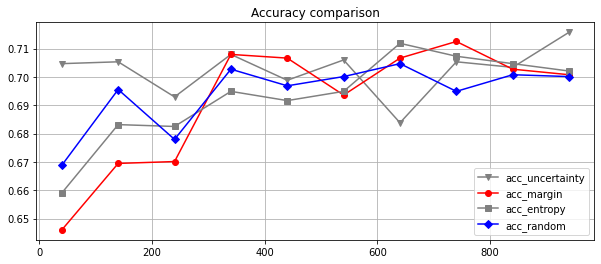

In [ ]:
print("Uncertainty avg: ",np.mean(result_rf_acc_uncertainty))
print("Margin avg: ",np.mean(result_rf_acc_margin))
print("Entropy avg: ",np.mean(result_rf_acc_entropy))
print("Random avg: ",np.mean(acc_random))
df = pd.DataFrame({'x_values':n_initial,'acc_uncertainty':np.array(result_rf_acc_uncertainty),'acc_margin':np.array(result_rf_acc_margin),'acc_entropy':np.array(result_rf_acc_entropy),'acc_random':np.array(acc_random)})

width_height_1 = (10, 4)
plt.figure(figsize=width_height_1)

plt.plot('x_values','acc_uncertainty',data=df,color='gray',marker='v')
plt.plot('x_values','acc_margin',data=df,color='red',marker='o')
plt.plot('x_values','acc_entropy',data=df,color='gray',marker='s')
plt.plot('x_values','acc_random',data=df,color='blue',marker='D')
plt.title('Accuracy comparison')
plt.legend()
plt.grid()
plt.show()